In [1]:
#%%capture

import pandas as pd
import numpy as np
import scipy as sp
import plotly
import folium
import os

import plotly.io as pio
pio.renderers.default='notebook'

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import ipywidgets
from IPython.core.display import HTML
from IPython.display import display, clear_output
import datetime
from io import StringIO

import trianer

plotly.offline.init_notebook_mode(connected=True)

%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Average metabolism

Human bodies need 3 types of types fuel to survive: 
- oxygen_2 through breathing
- water through drinking
- food trhough eating


## di-oxygen consumption

The quantity of oxygen used by a human on average is 3.5 ml of oxygen_2 per kilogram per minute, which is roughly equivalent to the energy expended when sitting quietly.

In [2]:
c = 3.5
print(f"Per kg, day: {60*24*c:.0f} ml/kg/day, hour: {60*c:.0f} ml/kg/hour, minute: {c:.1f} ml/kg/min")

age, height, weight, sex, activity = 42, 183, 80, "M", 0.7
print(f"Guillaume, day: {60*24*age*c/1000.:.1f} l/day, hour: {24*age*c/1000.:.2f} l/hour, minute: {age*c/1000.:.3f} l/min")

age, height, weight, sex, activity = 39, 169, 65, "F", 0.6
print(f"Sylvia, day: {60*24*age*c/1000.:.1f} l/day, hour: {24*age*c/1000.:.2f} l/hour, minute: {age*c/1000.:.3f} l/min")

Per kg, day: 5040 ml/kg/day, hour: 210 ml/kg/hour, minute: 3.5 ml/kg/min
Guillaume, day: 211.7 l/day, hour: 3.53 l/hour, minute: 0.147 l/min
Sylvia, day: 196.6 l/day, hour: 3.28 l/hour, minute: 0.137 l/min


## Water consumption

Water is essential to life. It constitutes the medium in which chemical reactions occur and is crucial to normal function of the cardiovascular system. Water constitutes about 70 percent of body weight in the normal adult. It decreases from 75 percent at birth to 50 percent in old age and is the largest component of the body. Adipose tissue contains less water than lean tissue; thus women have slightly less body water than men. The effects of dehydration occur with as little water loss as 1 percent of body weight and become life threatening at 10 percent (Adolph et al., 1947). Humans cannot adapt to a chronic water deficit, so fluid losses must be replaced if physiological function is to continue unimpaired.

| Intake Source | Amount (ml per day) | Source Output | Amount (ml per day) |
| --- | --- | --- | --- |
| Drinking | 1200 | Urine | 1400 |
|Food|	                        900|	Lungs and skin|	900|
|Oxidation|	                    300|	Feces|	100|
|Total|	                       2400|	Total|	2400|


Human water normal consumption is abour 2.4l per day.

In [3]:
d = 2400
print(f"Normal water consumption: {d/1000.:.1f} l/day, hour: {d/24.:.0f} ml/hour, minute: {d/24./60.:.2f} ml/min")

Normal water consumption: 2.4 l/day, hour: 100 ml/hour, minute: 1.67 ml/min



## Food consumption (calories consumption)

Energy in kcal = (4.184 J)

The Mifflin St Jeor equation gives the metabolism consumption per day

${\displaystyle P=\left({\frac {10.0m}{1~{\text{kg}}}}+{\frac {6.25h}{1~{\text{cm}}}}-{\frac {5.0a}{1~{\text{year}}}}+s\right){\frac {\text{kcal}}{\text{day}}},}$
where s is +5 for males and −161 for females.

Realized consumption:
- Digestion, thermal regulation: +10 %
- Posture, daily small activity: +10 %

On general, a correction factor has to be applied dependending on activity: 
- 1.2 no exercice, 
- 1.375 midly active (1-3 times/week), 
- 1.55 active (3-5 times/week), 
- 1.725 very active (6-7 times/week), 
- 1.9 Hyperactive

On considère généralement que les hommes ne devraient pas manger moins de 1500 kcal/j et les femmes 1200 kcal/j sur de longues périodes pour assurer un équilibre entre les principaux nutriments et micronutriments, et prévenir les déficits en vitamines et minéraux.

In [4]:
# Activity goes from 0 to 1
def get_metabolism_kcal_per_day(age, height, weight, sex, activity, time_unit="day"):
    """The Mifflin St Jeor equation implementation to get daily metabolism consumption"""
    
    # Calculate BMR, metabolism for mo
    s = 5 if sex == "M" else -161
    basal_metabolic_rate = 10 * weight + 6.25 * height -5 * age + s
    
    # Realized consumption:
    # - Digestion, thermal regulation: +10 %
    # - Posture, daily small activity: +10 %
    # On general, correction factor is: 1.2 no exercice, 1.375 midly active (1-3 times/week), 1.55 active (3-5 times/week), 1.725 very active (6-7 times/week), 1.9 Hyperactive
    coeff = np.linspace(1.2, 1.9, 10)[int(activity*10)]
    basal_metabolic_rate = coeff*basal_metabolic_rate
    
    if time_unit == "hour":
        basal_metabolic_rate /= 24
    elif time_unit in ["minute", "min"]:
        basal_metabolic_rate /= (24*60)
    
    return basal_metabolic_rate

age, height, weight, sex, activity = 42, 183, 80, "M", 0.7
rest_met = get_metabolism_kcal_per_day(age, height, weight, sex, activity)
print(f"Guillaume, day: {rest_met:.0f} kcal/day, hour: {rest_met/24.:.0f} kcal/hour, minute: {rest_met/24./60.:.3f} kcal/min, 1kg: {rest_met/24./60./weight:.3f} kcal/kg/min")

age, height, weight, sex, activity = 39, 169, 65, "F", 0.6
rest_met = get_metabolism_kcal_per_day(age, height, weight, sex, activity)
print(f"Sylvia, day: {rest_met:.0f} kcal/day, hour: {rest_met/24.:.0f} kcal/hour, minute: {rest_met/24./60.:.3f} kcal/min, 1kg: {rest_met/24./60./weight:.3f} kcal/kg/min")

Guillaume, day: 3033 kcal/day, hour: 126 kcal/hour, minute: 2.106 kcal/min, 1kg: 0.026 kcal/kg/min
Sylvia, day: 2250 kcal/day, hour: 94 kcal/hour, minute: 1.563 kcal/min, 1kg: 0.024 kcal/kg/min


# Metabolism and sport


Burnt calories seem to roughly be proportional to dioxygen consumption during exercice (should be fine in an aerobic regime).

$ \frac{VO_2}{Calories} \approx 200 ml/kcal/kg/min $ (**No reference found for this 200 factor**).

Then, we assume that the measure of dioxygen consumption is a way to estimate energy burnt during an exercice.

The metabolic equivalent of task (MET) is the objective measure of the ratio of the rate at which a person expends energy, relative to the mass of that person, while performing some specific physical activity compared to a reference, set by convention at 3.5 mL of oxygen per kilogram per minute, which is roughly equivalent to the energy expended when sitting quietly (40-year-old, 70 kg).


## MET

$Energy = MET \cdot \frac{3.5 \cdot weight}{200}$

A MET of 1 correspond to stay quiet sitting (meditation ?).
Comparing this estimation to the one coming from Mifflin St Jeor equation, we roughly get a MET of 1.4-1.5 for a normal day (Sylvia-Guillaume). 

In [9]:
age, height, weight, sex, activity = 42, 183, 80, "M", 0.7
rest_met = get_metabolism_kcal_per_day(age, height, weight, sex, activity, time_unit="min")
watts = 4184*rest_met/(c*weight/200)/60.
print(f"Guillaume, day: {c*weight/200*60*24:.0f} kcal/day, hour: {c*weight/200*60:.0f} kcal/hour, minute: {c*weight/200:.3f} kcal/min, 1kg: {c/200:.3f} kcal/kg/min ratio(Mifflin)= {rest_met/(c*weight/200):.2f} pow={watts:.0f} W")


age, height, weight, sex, activity = 39, 169, 65, "F", 0.6
rest_met = get_metabolism_kcal_per_day(age, height, weight, sex, activity, time_unit="min")
watts = 4184*rest_met/(c*weight/200)/60.
print(f"Sylvia, day: {c*weight/200*60*24:.0f} kcal/day, hour: {c*weight/200*60:.0f} kcal/hour, minute: {c*weight/200:.3f} kcal/min, 1kg: {c/200:.3f} kcal/kg/min ratio(Mifflin)= {rest_met/(c*weight/200):.2f} pow={watts:.0f} W")


Guillaume, day: 2016 kcal/day, hour: 84 kcal/hour, minute: 1.400 kcal/min, 1kg: 0.018 kcal/kg/min ratio(Mifflin)= 1.50 pow=105 W
Sylvia, day: 1638 kcal/day, hour: 68 kcal/hour, minute: 1.137 kcal/min, 1kg: 0.018 kcal/kg/min ratio(Mifflin)= 1.37 pow=96 W


## Recommendations

The American Heart AssociationTrusted Source recommends at least 150 minutes of moderate-intensity aerobic exercise each week for optimal cardiovascular health. That’s equal to about 500 MET minutes per week, according to the Department of Health and Human ServicesTrusted Source.

<AxesSubplot:>

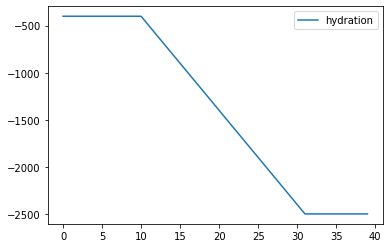

In [6]:
temp = np.arange(0, 40)
hydr = pd.Series(-np.clip(temp * 100 - 600, 400, 2500), index=temp).to_frame(name="hydration")
#hydr*=1.5
#sudation=5

hydr.plot()

In [7]:
Sweat Rate (liters per hour)
Subject	Hot-Wet Environment*	Hot-Dry Environment †	Neutral Environment ‡
KM	778	1247	178
JC	659	1198	302
MN	838	1234	272
BC	590	1159	265
Mean ± SE	715 ± 56	1210 ± 20	254 ± 27

SyntaxError: invalid character '†' (U+2020) (2827100651.py, line 2)

# Metabolism


### VO2 max measurement

Maximum oxygen used in aerobic exercice:
https://www.mdapp.co/vo2-max-calculator-for-aerobic-capacity-369/


Estimation of V̇O2 max from a timed one-mile track walk incorporating duration in minutes and seconds (t, e.g.: 20:35 would be specified as 20.58), gender, age, body weight in pounds (BW), and heart rate in 10 sec (HR) at the end of the mile.[7] The constant x is 6.3150 for males, 0 for females. BW is in lbs, time is in minutes.

$${{{\dot {V}}O2}}\max \approx 132.853-0.0769\cdot {\text{BW}}-0.3877\cdot {\text{age}}-3.2649t-0.1565\cdot {\text{HR}}+x$$

V̇O2 = 2.209 + 3.163 speed + 0.000525542 speed3


### vVO2 max measurement

Maximum oxygen used in aerobic exercice:
https://www.mdapp.co/vo2-max-calculator-for-aerobic-capacity-369/


### vVO2 max measurement


VO2 max based on 1.5 Mile Run / Walk Test
This VO2 max test requires an appropriate running location with a measured out distance of exactly 1.5 miles (2414 meters). A stopwatch must be used to record the exact time the distance is covered in. The subject can run and/or walk but the scope of the test is for the subject to cover the distance as fast as they can.

VO2 max = 483 / Test completion time (minutes) + 3.5

1 MET = 1.162 W/Kg


### FTP

Average power for 1 hour of bicycle

Function Threshold Power (FTP) is a measure of your cycling fitness and ability to maintain a high but manageable power output for a somewhat lengthy duration. From a physiological perspective, it’s the cycling power you produce when your lactate production has risen, leveled off, and then closely matches your body’s ability to remove lactate. This just barely keeps that lactate flooding at bay. In cycling, FTP is that grey area between the power you can sustain for a very long duration, typically an hour, and the fleeting power you can only tolerate for a couple of minutes.


20 Minute Test
One of the best-known testing methods is a 20-minute test. You’ll ride at your highest sustainable power for 20 minutes. Your FTP is 95% of the average power during this interval. This format can be challenging to pace correctly and is best done when you have fresh legs and a bit of practice.


## Energy spent versus energy delivered

cycling efficiency:
    
women had a gross efficiency (GE) of 23.2%, standard deviation 3.5 percentage points. Men had a GE of 21.2%,

https://www.researchgate.net/publication/24027428_Efficiency_in_cycling_A_review


running efficiency 
cycling / 5

speed/calories





In [ ]:
MB = 10*3.5*80/200*60

male_women_factor = 1.2

In [ ]:
60*24*7*3.5/1000

In [ ]:
483/2.414

In [ ]:
#VO2_max = 483 / Test completion time (minutes) + 3.5
VO2_max = 50
pace_km = 200 / (VO2_max - 3.5)
speed = 0.3 * (VO2_max - 3.5)

print(int(pace_km), 60*(pace_km-int(pace_km)))


print(speed)

In [ ]:
6/20

In [ ]:
import matplotlib.image as mpimg

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))
#fig.subplots_adjust(hspace=0)
fig.patch.set_facecolor("#cdcdcd")

speed = np.linspace(0.4, 2, 10)

df = pd.DataFrame({"speed": speed, "pace": 100./speed, "cal": 0.2*(speed)**3+0.5, "cal_kcal_h": 0.2*(speed)**3+0.5*speed*3600/4.184})

df.set_index("pace").sort_index()["cal_kcal_h"].plot(ax=axes[0][0])

axes[0][1].imshow(mpimg.imread('swimming.png'))

df.set_index("speed").sort_index()["cal_kcal_h"].plot(ax=axes[1][1])

# R&D

In [ ]:
triaainer.show_kcalories()

In [ ]:
trianer.get_kcalories(None).set_index(["discipline", "speed"])["MET 70 kg"]

In [ ]:
# Impact of 
import glob

fdata = trianer.enrich_data(pd.concat([trianer.get_data(filename=a) for a in glob.glob("pace_data/*") if not "Course" in a]))

fdata["speed"] = 3600 * (fdata["distance"].diff().ewm(10).mean() / fdata.dtime.diff().dt.seconds).fillna(0.)

cdata = fdata[fdata["speed"] > 10]
cdata["hr"] = cdata["hr"].astype(float).apply(lambda x: int(5 * round(float(x) / 5)))
#cdata["slope"] = cdata["slope"].astype(float).clip(-0.2, 0.2).round(2)#apply(lambda x: int(round(float(x) * 500) / 500))
cdata["slope"] = (cdata["slope"].astype(float)*100).clip(-30, 30).apply(lambda x: int(round(float(x) / 3) * 3))

cdata = cdata.groupby(["slope", "hr"]).mean()["speed"].to_frame("speed").reset_index()
print(cdata["slope"].unique())

import seaborn as sns

#sns.lineplot(x="hr", y="speed", hue="slope", data=cdata)


#print(cdata.groupby("hr")["speed"].mean())
cdata.groupby("hr")["speed"].mean().plot()
#sns.plot(cdata)

#x = np.arange(-2.5, 15, 0.1)
#y = 32-x*1.2
#plt.plot(x, y)


In [ ]:
temp = np.arange(0, 40)
hydr = pd.Series(-np.clip(temp * 100 - 600, 400, 2500), index=temp).to_frame(name="hydration")
hydr*=1.5
sudation=5

hydr.plot()


In [ ]:
import glob


fdata = triaainer.enrich_data(pd.concat([triaainer.get_data(filename=a) for a in glob.glob("pace_data/*") if "Course" in a]))

fdata["speed"] = 3600 * (fdata["distance"].diff() / fdata.dtime.diff().dt.seconds).ewm(10).mean().fillna(0.)

cdata = fdata[fdata["speed"] > 7]
cdata["hr"] = cdata["hr"].astype(float)#.hist()

cdata["sslope"] = pd.Series(cdata["slope"]).round()

cdata.groupby("sslope").mean()["speed"].plot()
x = np.arange(-2.5, 15, 0.1)
y = 10-x*0.1
plt.plot(x, y)


In [ ]:
! ls races